In [1]:
# ch2/ch2_2_auto_sarima/auto_sarima.ipynb
# 标准库
import sys

# 第三方模块
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm

# 自定义模块
sys.path.append('./../../')
import utils.dataset as udataset
import utils.metrics as umetrics
import utils.plot as uplot

# 绘图参数
name_model = 'AUTO_SARIMA'
name_var = '销量'
name_unit = ''
uplot.set_matplotlib(plot_dpi=80, save_dpi=600, font_size=12)


,序列长度,最大值,最小值,均值,标准差,偏度,峰度
0,176,40226,13652,25392.15,5340.82,0.46,0.1


data.shape=(176, 1)
train.shape=(150, 1), test.shape=(26, 1)


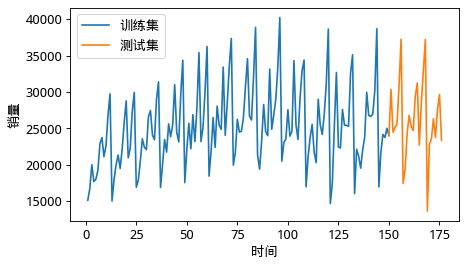

In [2]:
# 数据读取
data = pd.read_csv('./data/data_winesales.csv', parse_dates=['date'])
data = data.set_index('date')
udataset.stats(data)
print(f'{data.shape=}')

# 训练测试划分
num_train = 150
train, test = pm.model_selection.train_test_split(data, train_size=num_train)
print(f'{train.shape=}, {test.shape=}')

# 可视化
uplot.plot_dataset(
    train.values,
    test.values,
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'原始序列_{name_model}'
)


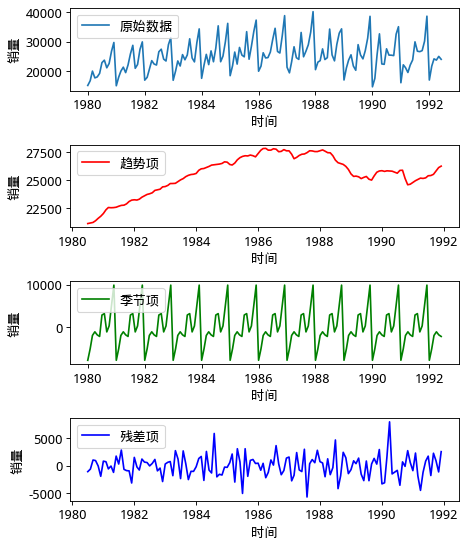

In [3]:
# 季节性分解
decomposition = seasonal_decompose(
    train,  # 时间序列
    model='addictive',  # 季节分量类型
)

# 季节性分解可视化
uplot.plot_decomposition(
    series=train,
    decomposition=decomposition,
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'季节分解_{name_model}'
)


In [4]:
# 搜索上限
max_value = 2  # 若计算资源充足可增大此参数

# 模型搜索/训练
model = pm.auto_arima(
    train,

    start_p=0,
    d=None,
    start_q=0,
    max_p=max_value,
    nax_d=3,
    max_q=max_value,

    start_P=0,
    D=None,
    start_Q=0,
    max_P=max_value,
    max_D=1,
    max_Q=max_value,
    max_order=20,
    m=12,
    seasonal=True,

    information_criterion='bic',
    stepwise=False,
    n_jobs=2,  # 若计算资源充足可增大此参数
    trace=True,

    suppress_warnings=True,
    error_action='ignore',

    n_fits=10,
    scoring='mse'
)



Best model:  ARIMA(0,1,1)(1,0,1)[12] intercept
Total fit time: 20.977 seconds


In [5]:
# 测试
pred, conf_int = model.predict(
    n_periods=test.shape[0],  # 超前预测步数
    return_conf_int=True,  # 获取预测的置信区间
    alpha=0.05  # 预测的置信区间为(1-alpha)%
)

# 误差评价
umetrics.all_metrics(test.values, pred.values)


mse=6104337.631
rmse=2470.696
mae=1838.057
mape=8.293%
sde=2322.775
r2=0.778
pcc=0.916


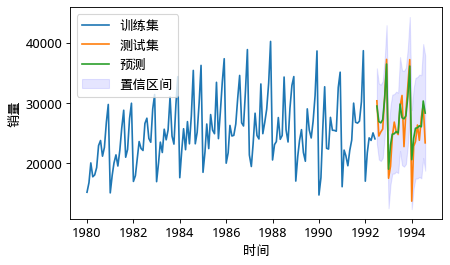

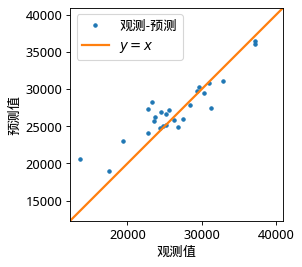

In [6]:
# 可视化
plt.figure(figsize=(6, 3.5))
plt.plot(train, label='训练集')
plt.plot(test, label='测试集')
plt.plot(pred, label='预测')
plt.fill_between(
    pred.index,
    conf_int[:, 0], 
    conf_int[:, 1],
    alpha=0.1, 
    color='b',
    label='置信区间'
)

plt.legend(loc='upper left')
plt.xlabel('时间')
plt.ylabel(f'{name_var}{name_unit}')
plt.savefig(f'./fig/预测结果_{name_model}.jpg', bbox_inches='tight')
plt.show()

uplot.plot_parity(
    y_true=test.values,
    y_pred=pred.values,
    xlabel=f'观测值{name_unit}',
    ylabel=f'预测值{name_unit}',
    fig_name=f'{name_model}_Parity'
)